In [5]:
import os
import numpy as np
import pandas as pd
import sys
import csv
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler, LambdaCallback
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint

from keras.metrics import categorical_accuracy, binary_accuracy
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import StratifiedKFold, KFold

In [16]:
%matplotlib inline

# Variables to be changed

In [6]:
taskname = "verytoxic"             ## Specify task to be predicted
tasktype = "classification"  ## Specify either classification or regression
datarep = "image"          ## Specify data representation

In [10]:
# Specify dataset name
jobname = "tox_niehs"

# Specify location of data
homedir = os.path.dirname(os.path.realpath('__file__'))+"/data/"
network_name = ""
if datarep == "image":
    network_name = "cnn"
    archdir = os.path.dirname(os.path.realpath('__file__'))+"/data/archive/"
    K.set_image_dim_ordering('tf')
    pixel = 80
    num_channel = 4
    channel = "engA"
elif datarep == "tabular":
    network_name = "mlp"
    archdir = os.path.dirname(os.path.realpath('__file__'))+"/data/"
elif datarep == "text":
    network_name = "rnn"
    archdir = os.path.dirname(os.path.realpath('__file__'))+"/data/"

# Loading Data

In [8]:
from chem_scripts import cs_load_csv, cs_load_smiles, cs_load_image, cs_create_dict, cs_prep_data_X, cs_prep_data_y, cs_data_balance
from chem_scripts import cs_compute_results, cs_keras_to_seaborn, cs_make_plots
from chem_scripts import cs_setup_mlp, cs_setup_rnn, cs_setup_cnn

In [11]:
if datarep == "tabular":

    # Load training + validation data
    filename=archdir+jobname+"_tv_"+taskname+"_rdkit.csv"
    X, y = cs_load_csv(filename)

    # Load test data
    filename=archdir+jobname+"_int_"+taskname+"_rdkit.csv"
    X_test, y_test = cs_load_csv(filename)
    if tasktype == "classification":
        y_test, _ = cs_prep_data_y(y_test, tasktype=tasktype)
        
elif datarep == "text":
    
    # Load training + validation data
    filename=archdir+jobname+"_tv_"+taskname+"_smiles.csv"
    X, y = cs_load_smiles(filename)
    
    # Load test data
    filename=archdir+jobname+"_int_"+taskname+"_smiles.csv"
    X_test, y_test = cs_load_smiles(filename)
    if tasktype == "classification":
        y_test, _ = cs_prep_data_y(y_test, tasktype=tasktype)
    
    # Create dictionary
    characters, char_table, char_lookup = cs_create_dict(X, X_test)
    
    # Map chars to integers
    X = cs_prep_data_X(X, datarep=datarep, char_table=char_table)
    X_test = cs_prep_data_X(X_test, datarep=datarep, char_table=char_table)
    
elif datarep == "image":

    # Load training + validation data
    filename=archdir+jobname+"_tv_"+taskname
    X, y = cs_load_image(filename, channel=channel)

    # Load test data
    filename=archdir+jobname+"_int_"+taskname 
    X_test, y_test = cs_load_image(filename, channel=channel)
    if tasktype == "classification":
        y_test, _ = cs_prep_data_y(y_test, tasktype=tasktype)

    # Reshape X to be [samples][channels][width][height]
    X = X.reshape(X.shape[0], pixel, pixel, num_channel).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], pixel, pixel, num_channel).astype("float32")

y dim: (820, 2)
y no. class: 2


In [12]:
def f_nn(train_default=True):

    # Define counter for hyperparam iterations
    global run_counter
    run_counter += 1
        
    print('*** TRIAL: '+str(run_counter))
    print('*** PARAMETERS TESTING: '+str(params))
    
    # Intialize results file
    # Setup cross-validation
    if tasktype == "classification":
        cv_results = pd.DataFrame(columns=['Train Loss', 'Validation Loss', 'Test Loss', 'Train AUC', 'Validation AUC', 'Test AUC'])
        stratk = StratifiedKFold(n_splits=5, random_state=7)
        splits = stratk.split(X, y)
    elif tasktype == "regression":
        cv_results = pd.DataFrame(columns=['Train Loss', 'Validation Loss', 'Test Loss', 'Train RMSE', 'Validation RMSE', 'Test RMSE'])
        stratk = KFold(n_splits=5, random_state=7)
        splits = stratk.split(X, y)

    # Do cross-validation
    for i, (train_index, valid_index) in enumerate(splits):

        if prototype == True:
            if i > 0:
                break

        print("\nOn CV iteration: "+str(i))
        # Do standard k-fold splitting
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        print("BEFORE Sampling: "+str(i)+" Train: "+str(X_train.shape)+" Valid: "+str(X_valid.shape))
        print("BEFORE Sampling: "+str(i)+" Train: "+str(y_train.shape)+" Valid: "+str(y_valid.shape))

        if tasktype == "classification":
        
            # Do class-balancing
            balanced_indices = cs_data_balance(y_train)
            X_train = X_train[balanced_indices]
            y_train = y_train[balanced_indices]
            
            balanced_indices = cs_data_balance(y_valid)
            X_valid = X_valid[balanced_indices]
            y_valid = y_valid[balanced_indices]
            
            # One-hot encoding
            y_train, y_class = cs_prep_data_y(y_train, tasktype=tasktype)   #ONLY DO THIS AFTER SPLITTING
            y_valid, y_class = cs_prep_data_y(y_valid, tasktype=tasktype)
            print("AFTER Sampling: "+str(i)+" Train: "+str(X_train.shape)+" Valid: "+str(X_valid.shape))
            print("AFTER Sampling: "+str(i)+" Train: "+str(y_train.shape)+" Valid: "+str(y_valid.shape))
            
        elif tasktype == "regression":
            
            y_class = 1

        # Setup network
        if datarep == "tabular":
            model, submodel = cs_setup_mlp(params, inshape=X_train.shape[1], classes=y_class)
        elif datarep == "text":
            model, submodel = cs_setup_rnn(params, inshape=X_train.shape[1], classes=y_class, char=characters)
        elif datarep == "image":
            model, submodel = cs_setup_cnn(params, inshape=(pixel, pixel, num_channel), classes=y_class)
        
        if i == 0:
            # Print architecture
            print(model.summary())
            # Save model
            model_json = submodel.to_json()
            filemodel=jobname+"_"+network_name+"_"taskname+"_architecture_"+str(run_counter)+".json"
            with open(filemodel, "w") as json_file:
                json_file.write(model_json)

        # Setup callbacks
        filecp = jobname+"_"+network_name+"_"+taskname+"_bestweights_trial_"+str(run_counter)+"_"+str(i)+".hdf5"
        filecsv = jobname+"_"+network_name+"_"+taskname+"_loss_curve_"+str(run_counter)+"_"+str(i)+".csv"
        callbacks = [TerminateOnNaN(),
                     LambdaCallback(on_epoch_end=lambda epoch,logs: sys.stdout.flush()),
                     EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto'),
                     ModelCheckpoint(filecp, monitor="val_loss", verbose=1, save_best_only=True, mode="auto"),
                     CSVLogger(filecsv)]
        
        # Train model
        if datarep == "image":
            datagen = ImageDataGenerator(rotation_range=180, fill_mode='constant', cval=0.)
            hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                       epochs=nb_epoch, steps_per_epoch=X_train.shape[0]/batch_size,
                                       verbose=verbose,
                                       validation_data=(X_valid, y_valid),
                                       callbacks=callbacks)
        else:
            hist = model.fit(x=X_train, y=y_train,
                             batch_size=batch_size,
                             epochs=nb_epoch,
                             verbose=verbose,
                             validation_data=(X_valid, y_valid),
                             callbacks=callbacks)

        # Visualize loss curve
        hist_df = cs_keras_to_seaborn(hist)
        cs_make_plots(hist_df)
        
        # Reload best model & compute results
        model.load_weights(filecp)
        y_preds_result = cs_compute_results(model, classes=y_class, df_out=cv_results,
                                            train_data=(X_train,y_train),
                                            valid_data=(X_valid,y_valid),
                                            test_data=(X_test,y_test))
    
    # Calculate results for entire CV
    final_mean = cv_results.mean(axis=0)
    final_std = cv_results.std(axis=0)
    cv_results.to_csv('results_'+jobname+'_'+network_name+'_'+taskname+'.csv', index=False)
    
    # ouput prediction of testset
    with open("predictions_"+jobname+"_"+network_name+"_"+taskname+".csv", "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        writer.writerows(y_preds_result)
        
    # Print final results
    print('*** TRIAL RESULTS: '+str(run_counter))
    print('*** PARAMETERS TESTED: '+str(params))
    
    if tasktype == "regression":
        print(('train_loss: %.3f +/- %.3f, train_rmse: %.3f +/- %.3f, val_loss: %.3f +/- %.3f, val_rmse: %.3f +/- %.3f, test_loss: %.3f +/- %.3f, test_rmse: %.3f +/- %.3f')
              %(final_mean[0], final_std[0], final_mean[3], final_std[3],
                final_mean[1], final_std[1], final_mean[4], final_std[4],
                final_mean[2], final_std[2], final_mean[5], final_std[5]))
    elif tasktype == "classification":
        print(('train_loss: %.3f +/- %.3f, train_auc: %.3f +/- %.3f, val_loss: %.3f +/- %.3f, val_auc: %.3f +/- %.3f, test_loss: %.3f +/- %.3f, test_auc: %.3f +/- %.3f')
              %(final_mean[0], final_std[0], final_mean[3], final_std[3],
                final_mean[1], final_std[1], final_mean[4], final_std[4],
                final_mean[2], final_std[2], final_mean[5], final_std[5]))

In [13]:
# Network hyperparameters

# Hyperparams:
# Dropout: 0 to 0.5 (float)
# num_layer: 2 to 6 (int)
# relu_type: relu, elu, leakyrelu, prelu
# layerN_units: 16, 32, 64, 128, 256 (int)
# reg_flag: l1, l2, l1_l2, none
# reg_val: 1 to 6 (float)
if datarep == "tabular":
    params = {"dropval":0.5, "num_layer":2, "relu_type":"prelu",
              "layer1_units":128, "layer2_units":128, "layer3_units":128,
              "layer4_units":128, "layer5_units":128, "layer6_units":128,
              "reg_type": "l2", "reg_val": 2.5 }
    
# Hyperparams:
# Dropout: 0 to 0.5 (float)
# em_dim: 1 to 10 (int)
# num_layer: 1 to 3 (int)
# relu_type: relu, elu, leakyrelu, prelu
# conv units: 16, 32, 64, 128, 256 (int)
# layerN_units: 16, 32, 64, 128, 256 (int)
elif datarep == "text":
    params = {"em_dim":5, "conv_units":6, "dropval":0.5, "num_layer":2,
              "celltype":"GRU", "relu_type":"prelu",
              "layer1_units":12, "layer2_units":12, "layer3_units":12,
              "reg_type": "l2", "reg_val": 2}

# Hyperparams:
# Dropout: 0 to 0.5 (float)
# num_blockN: 1 to 5 (int)
# convN units: 16, 32, 64, 128, 256 (int)
elif datarep == "image":
    params = {"conv1_units":32, "conv2_units":32, "conv3_units":32,
              "conv4_units":32, "conv5_units":32, "conv6_units":32,
              "num_block1":3, "num_block2":3, "num_block3":3, "dropval":0}

In [14]:
# Run settings

run_counter = 0
batch_size = 128
nb_epoch = 5
verbose = 1
prototype = True

*** TRIAL: 1
*** PARAMETERS TESTING: {'conv1_units': 32, 'conv2_units': 32, 'conv3_units': 32, 'conv4_units': 32, 'conv5_units': 32, 'conv6_units': 32, 'num_block1': 3, 'num_block2': 3, 'num_block3': 3, 'dropval': 0}

On CV iteration: 0
BEFORE Sampling: 0 Train: (5996, 80, 80, 4) Valid: (1500, 80, 80, 4)
BEFORE Sampling: 0 Train: (5996,) Valid: (1500,)
y dim: (10984, 2)
y no. class: 2
y dim: (2748, 2)
y no. class: 2
AFTER Sampling: 0 Train: (10984, 80, 80, 4) Valid: (2748, 80, 80, 4)
AFTER Sampling: 0 Train: (10984, 2) Valid: (2748, 2)
Channel axis is -1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 

d:\Users\Huang\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


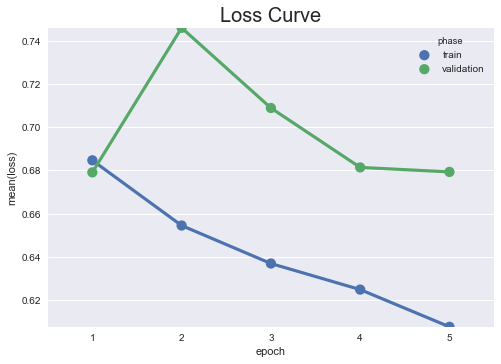


FINAL TRA_LOSS: 0.661
FINAL VAL_LOSS: 0.679
FINAL TST_LOSS: 0.676
FINAL TRA_AUC: 0.691
FINAL VAL_AUC: 0.601
FINAL TST_AUC: 0.739
*** TRIAL RESULTS: 1
*** PARAMETERS TESTED: {'conv1_units': 32, 'conv2_units': 32, 'conv3_units': 32, 'conv4_units': 32, 'conv5_units': 32, 'conv6_units': 32, 'num_block1': 3, 'num_block2': 3, 'num_block3': 3, 'dropval': 0}
train_loss: 0.661 +/- nan, train_auc: 0.691 +/- nan, val_loss: 0.679 +/- nan, val_auc: 0.601 +/- nan, test_loss: 0.676 +/- nan, test_auc: 0.739 +/- nan


In [15]:
# if train_default is true, models will be trained.
# otherwise, the model will read saved weight from file.
f_nn(True)